In [1]:
 import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

In [2]:
print(tf.config.list_physical_devices())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# Constants
BATCH_SIZE = 32
IMAGE_SIZE = 128  # Adjust the image size according to your dataset
CHANNELS = 3
EPOCHS = 30

In [4]:
# Load dataset
dataset_dir = "Segmented"

In [5]:
# Load the entire dataset without splitting
full_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
)

Found 3256 files belonging to 4 classes.


In [6]:
class_names = full_ds.class_names
class_names

['Benign', 'Early', 'Pre', 'Pro']

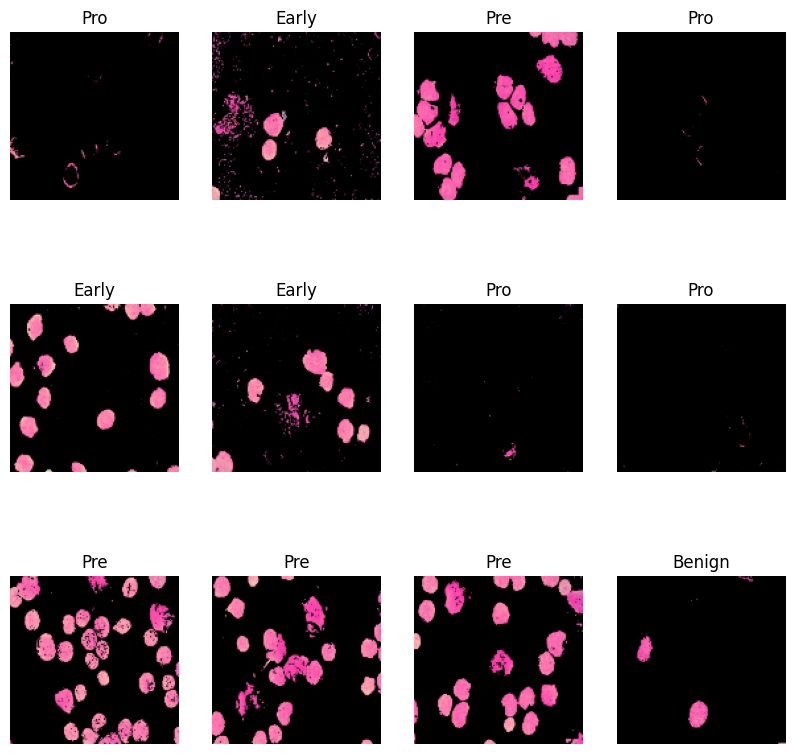

In [7]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in full_ds.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [8]:
# 80% ===> training
# 10% ==> validation
# 10% ==> test 

In [9]:
# Calculate the total number of samples in the dataset
dataset_size = len(full_ds)
dataset_size

102

In [10]:
# Calculate the number of samples for each subset
train_size = int(0.8 * dataset_size)
val_size = int(0.1 * dataset_size)
test_size = dataset_size - train_size - val_size


In [11]:
# Split the dataset into train, validation, and test subsets
train_ds = full_ds.take(train_size)
test_ds = full_ds.skip(train_size)
val_ds = test_ds.skip(test_size)
test_ds = test_ds.take(test_size)

In [13]:
# Data augmentation and normalization
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])
preprocess_input = tf.keras.applications.resnet.preprocess_input

In [14]:
# Model
base_model = tf.keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
)
base_model.trainable = False

inputs = tf.keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(len(full_ds.class_names), activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

In [15]:
# Compile the model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [16]:
# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)

Epoch 1/30
81/81 [==============================] - 26s 155ms/step - loss: 0.3264 - accuracy: 0.8835 - val_loss: 0.1864 - val_accuracy: 0.9391
Epoch 2/30
81/81 [==============================] - 10s 118ms/step - loss: 0.1758 - accuracy: 0.9379 - val_loss: 0.1331 - val_accuracy: 0.9583
Epoch 3/30
81/81 [==============================] - 10s 117ms/step - loss: 0.1507 - accuracy: 0.9456 - val_loss: 0.1866 - val_accuracy: 0.9487
Epoch 4/30
81/81 [==============================] - 10s 118ms/step - loss: 0.1292 - accuracy: 0.9537 - val_loss: 0.1283 - val_accuracy: 0.9551
Epoch 5/30
81/81 [==============================] - 10s 118ms/step - loss: 0.1158 - accuracy: 0.9587 - val_loss: 0.1233 - val_accuracy: 0.9615
Epoch 6/30
81/81 [==============================] - 10s 117ms/step - loss: 0.1127 - accuracy: 0.9622 - val_loss: 0.1508 - val_accuracy: 0.9583
Epoch 7/30
81/81 [==============================] - 10s 118ms/step - loss: 0.1169 - accuracy: 0.9552 - val_loss: 0.1250 - val_accuracy: 0.9391

In [17]:
scores =model.evaluate(test_ds)

11/11 [==============================] - 2s 83ms/step - loss: 0.1627 - accuracy: 0.9545


In [18]:
scores

[0.16273008286952972, 0.9545454382896423]

In [19]:
history

In [21]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 81}

In [22]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [23]:
history.history['accuracy']

[0.8834876418113708,
 0.9378858208656311,
 0.9456018805503845,
 0.9537037014961243,
 0.9587191343307495,
 0.9621913433074951,
 0.9552469253540039,
 0.9529321193695068,
 0.966821014881134,
 0.9656635522842407,
 0.9645061492919922,
 0.9664351940155029,
 0.9733796119689941,
 0.9679784178733826,
 0.9699074029922485,
 0.9664351940155029,
 0.9679784178733826,
 0.9718364477157593,
 0.9729938507080078,
 0.9729938507080078,
 0.9664351940155029,
 0.9741512537002563,
 0.9753086566925049,
 0.9764660596847534,
 0.9749228358268738,
 0.9718364477157593,
 0.9772376418113708,
 0.970678985118866,
 0.9795524477958679,
 0.9772376418113708]

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

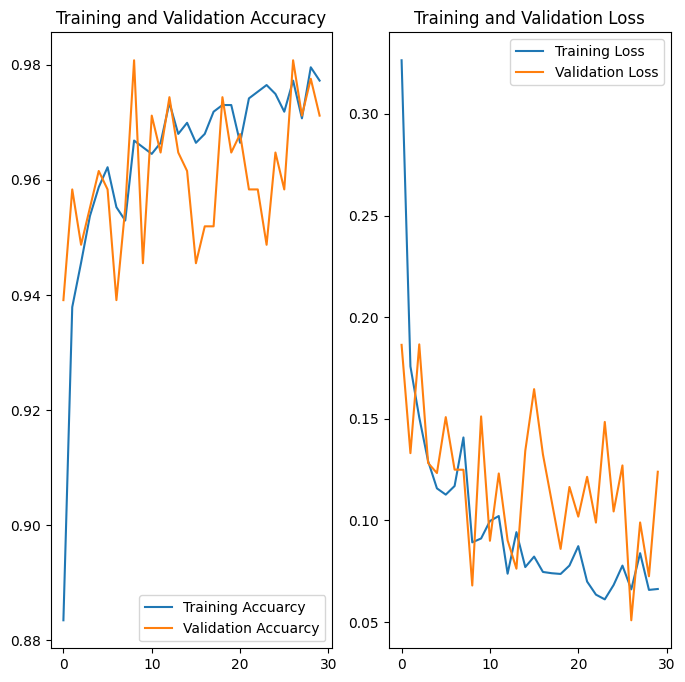

In [25]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label ="Training Accuarcy")
plt.plot(range(EPOCHS), val_acc, label ="Validation Accuarcy")
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label ="Training Loss")
plt.plot(range(EPOCHS), val_loss , label ="Validation Loss")
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

first image to predict
first image's actual label: Pre
PREDICTED LABEL :  Pre


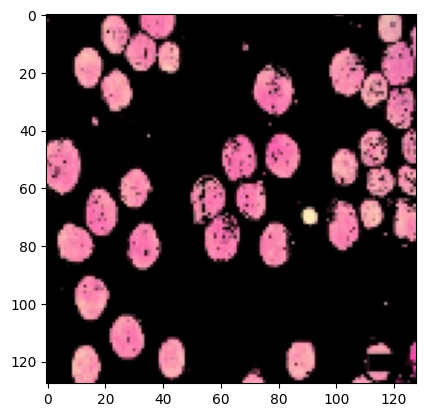

In [26]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("first image's actual label:", class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("PREDICTED LABEL : ", class_names[np.argmax(batch_prediction[0])])

In [27]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) #Create a batch

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

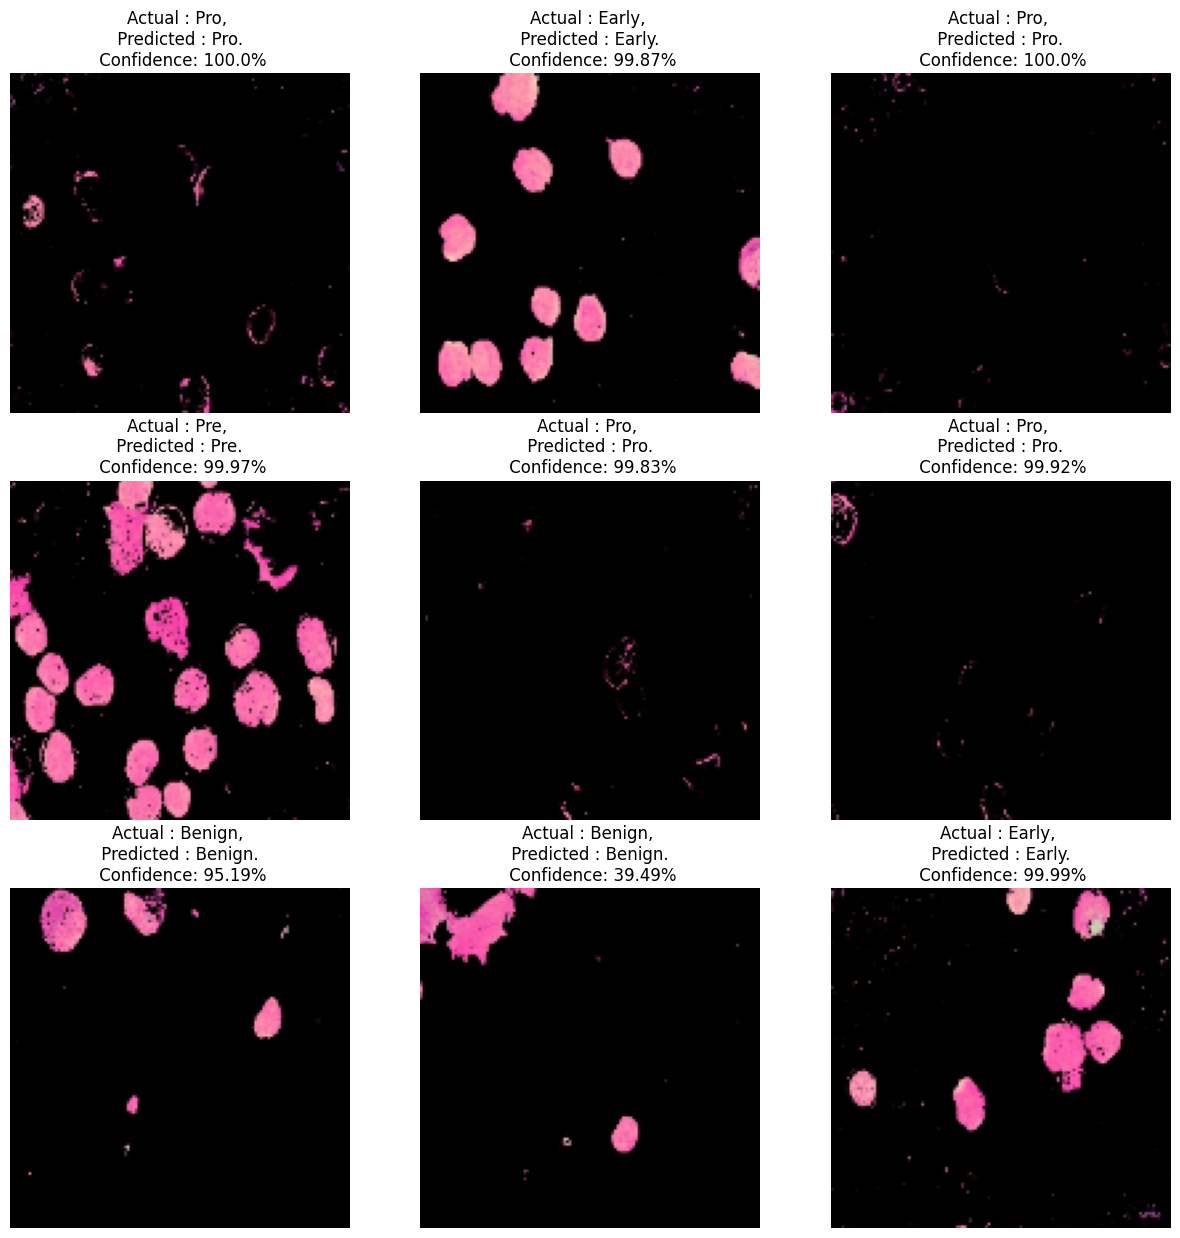

In [28]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual : {actual_class}, \n Predicted : {predicted_class}. \n Confidence: {confidence}%")
        
        plt.axis('off')

In [29]:
model_version= '7'
model.save(f"../{model_version}")

C:\Users\21623\anaconda3\envs\oussama\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: ../saved_models/7\assets
